In [29]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [30]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [31]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [32]:
def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - (tx @ w)
    return (e.T @ e) / (2 * len(y))

# 2 Grid Search

Fill in the function `grid_search()` below:

In [33]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i, w0_v in enumerate(w0):
        for j, w1_v in enumerate(w1):
            losses[i,j] = compute_loss(y, tx, np.array([w0_v, w1_v]))
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.424483146782485, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.023 seconds


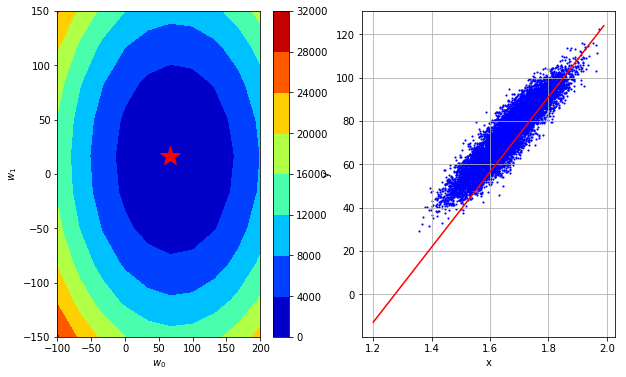

In [34]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [35]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y - (tx @ w)
    return - (tx.T @ e) / len(y)

Please fill in the functions `gradient_descent` below:

In [36]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        w = w - gamma * compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [37]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=265.3024621089608, w0=51.3057454014736, w1=9.435798704492266
Gradient Descent(1/49): loss=37.878379550441274, w0=66.69746902191571, w1=12.266538315839991
Gradient Descent(2/49): loss=17.410212120174478, w0=71.31498610804834, w1=13.115760199244328
Gradient Descent(3/49): loss=15.568077051450457, w0=72.70024123388814, w1=13.37052676426563
Gradient Descent(4/49): loss=15.402284895265295, w0=73.11581777164007, w1=13.446956733772023
Gradient Descent(5/49): loss=15.38736360120863, w0=73.24049073296565, w1=13.469885724623941
Gradient Descent(6/49): loss=15.386020684743528, w0=73.27789262136334, w1=13.476764421879516
Gradient Descent(7/49): loss=15.38589982226167, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.385888944638301, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=15.3858879656522, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=15.385887877543452, w0=73.29379216412119, w1=13.47

In [38]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4 Stochastic gradient descent

In [39]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    e = y - (tx @ w)
    return - (tx.T @ e) / len(y)


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    for t_y, t_tx in batch_iter(y, tx, batch_size, num_batches=max_iters):
        w = w - gamma * compute_gradient(t_y, t_tx, w)
        loss = compute_loss(t_y, t_tx, w)
        # store w and loss
        ws.append(w)
        losses.append(loss)
        
    return losses, ws

In [40]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.003 seconds


In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load and plot data containing outliers

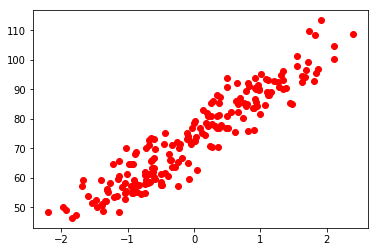

In [41]:

height1, weight1, gender1 = load_data(sub_sample=True, add_outlier=False)
x1, mean_x1, std_x1 = standardize(height1)
y1, tx1 = build_model_data(x1, weight1)

plt.plot(tx1[:,1], y1, 'ro')

In [42]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.3

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses1, gradient_ws1 = gradient_descent(y1, tx1, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=1393.301541728699, w0=22.08968173791935, w1=4.342711462931176
Gradient Descent(1/49): loss=689.6759072009392, w0=37.55245895446288, w1=7.382609486982988
Gradient Descent(2/49): loss=344.89934628233624, w0=48.376403006043354, w1=9.510538103819245
Gradient Descent(3/49): loss=175.9588314322212, w0=55.953163842149685, w1=11.000088135604617
Gradient Descent(4/49): loss=93.1779791556649, w0=61.25689642742412, w1=12.042773157854372
Gradient Descent(5/49): loss=52.61536154015235, w0=64.96950923711621, w1=12.772652673429198
Gradient Descent(6/49): loss=32.73967890855122, w0=67.56833820390068, w1=13.283568334331573
Gradient Descent(7/49): loss=23.000594419066637, w0=69.38751848064982, w1=13.641209296963233
Gradient Descent(8/49): loss=18.2284430192192, w0=70.6609446743742, w1=13.891557970805394
Gradient Descent(9/49): loss=15.890088833293948, w0=71.55234300998129, w1=14.066802042494906
Gradient Descent(10/49): loss=14.744295282190576, w0=72.17632184490624, w1=14.189

In [43]:

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses1, gradient_ws1, grid_losses, grid_w0, grid_w1, mean_x1, std_x1, height1, weight1, n_iter)
    fig.set_size_inches(10.0, 6.0)
interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

In [44]:

height1, weight1, gender1 = load_data(sub_sample=True, add_outlier=True)
x1, mean_x1, std_x1 = standardize(height1)
y1, tx1 = build_model_data(x1, weight1)


In [45]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.3

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses1, gradient_ws1 = gradient_descent(y1, tx1, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=1439.8438784748948, w0=22.22034175647792, w1=3.3104684597967604
Gradient Descent(1/49): loss=739.1481728050259, w0=37.77458098601246, w1=5.6277963816544805
Gradient Descent(2/49): loss=395.8072770267905, w0=48.66254844668663, w1=7.249925926954881
Gradient Descent(3/49): loss=227.57023809545484, w0=56.284125669158556, w1=8.385416608665155
Gradient Descent(4/49): loss=145.13408901910066, w0=61.619229724888896, w1=9.180260085862344
Gradient Descent(5/49): loss=104.74037597168706, w0=65.35380256390013, w1=9.736650519900374
Gradient Descent(6/49): loss=84.94745657845439, w0=67.968003551208, w1=10.126123823726997
Gradient Descent(7/49): loss=75.24892607577037, w0=69.79794424232351, w1=10.39875513640563
Gradient Descent(8/49): loss=70.49664612945521, w0=71.07890272610436, w1=10.589597055280672
Gradient Descent(9/49): loss=68.16802895576079, w0=71.97557366475097, w1=10.723186398493201
Gradient Descent(10/49): loss=67.0270065406505, w0=72.60324332180359, w1=10.81669

In [46]:

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses1, gradient_ws1, grid_losses, grid_w0, grid_w1, mean_x1, std_x1, height1, weight1, n_iter)
    fig.set_size_inches(10.0, 6.0)
interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)

In [76]:
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)


In [77]:
def compute_loss_mae(y, tx, w):
    """Calculate the loss for mae.
    """
    e = y - (tx @ w)
    return np.sum(np.abs(e)) / len(y)

def compute_gradient_mae(y, tx, w):
    """Calculate the gradient for mae.

    """
    subgrad =  0.5 * np.sum(tx, axis=0) / len(y)
    e = y - (tx @ w)
    s = np.sign(e)
    s[s == 0] = 0.1
    grad = - tx.T @ s / len(y)
    return grad

def gradient_descent_mae(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        w = w - gamma * compute_gradient_mae(y, tx, w)
        loss = compute_loss_mae(y, tx, w)
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws



In [78]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i, w0_v in enumerate(w0):
        for j, w1_v in enumerate(w1):
            losses[i,j] = compute_loss_mae(y, tx, np.array([w0_v, w1_v]))
    return losses

In [79]:
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)

In [80]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 5

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent_mae(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=69.06780585492638, w0=5.0, w1=6.2546227822941986e-15
Gradient Descent(1/49): loss=64.06780585492638, w0=10.0, w1=1.2509245564588397e-14
Gradient Descent(2/49): loss=59.067805854926384, w0=15.0, w1=1.8763868346882595e-14
Gradient Descent(3/49): loss=54.06780585492638, w0=20.0, w1=2.5018491129176794e-14
Gradient Descent(4/49): loss=49.06780585492638, w0=25.0, w1=3.127311391147099e-14
Gradient Descent(5/49): loss=44.067805854926384, w0=30.0, w1=3.752773669376519e-14
Gradient Descent(6/49): loss=39.06780585492638, w0=35.0, w1=4.378235947605939e-14
Gradient Descent(7/49): loss=34.06780585492638, w0=40.0, w1=5.003698225835359e-14
Gradient Descent(8/49): loss=29.067805854926373, w0=45.0, w1=5.629160504064779e-14
Gradient Descent(9/49): loss=24.186081863361224, w0=50.0, w1=6.254622782294198e-14
Gradient Descent(10/49): loss=19.9796096506457, w0=54.7029702970297, w1=0.44344586746332243
Gradient Descent(11/49): loss=16.62722280243286, w0=58.81188118811881, w1=1.61467

In [81]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

In [82]:

def stochastic_gradient_descent_mae(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for t_y, t_tx in batch_iter(y, tx, batch_size, num_batches=max_iters):
        w = w - gamma * compute_gradient_mae(t_y, t_tx, w)
        loss = compute_loss_mae(t_y, t_tx, w)
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent loss={l}, w0={w0}, w1={w1}".format(l=loss, w0=w[0], w1=w[1]))

    return losses, ws



In [93]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 5
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent_mae(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent loss=39.04884772918177, w0=5.0, w1=-6.977124849585135
Gradient Descent loss=45.45047748644008, w0=10.0, w1=-11.150785832055787
Gradient Descent loss=84.96437756061081, w0=15.0, w1=-3.5942479261446563
Gradient Descent loss=9.500920169983374, w0=20.0, w1=-11.378498090953373
Gradient Descent loss=66.20610381914119, w0=25.0, w1=-4.534676013083322
Gradient Descent loss=13.72641737895696, w0=30.0, w1=-10.136338356221353
Gradient Descent loss=29.511252074179254, w0=35.0, w1=-10.317036680427362
Gradient Descent loss=16.888141231894352, w0=40.0, w1=-12.819443347344443
Gradient Descent loss=36.96733486305203, w0=45.0, w1=-10.424957238035478
Gradient Descent loss=5.73621245197382, w0=40.0, w1=-4.424760299036828
Gradient Descent loss=4.345453685626005, w0=45.0, w1=-8.056911140035638
Gradient Descent loss=51.56054359689122, w0=50.0, w1=1.6957278075615836
Gradient Descent loss=1.220217325207365, w0=55.0, w1=-3.2798775584438644
Gradient Descent loss=32.17522163440041, w0=60.0, w1=-0.

In [94]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>